!pip install kaggle -q

importing dependencies

In [ ]:
import os
import json

import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

Data collection

In [ ]:
kaggle_config = json.load(open("kaggle.json"))


In [ ]:
kaggle_config.keys()


dict_keys(['username', 'key'])

In [ ]:
# Set the environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_config['username']
os.environ['KAGGLE_KEY'] = kaggle_config['key']

In [ ]:
# loadig the dataset using kaggle api
!kaggle datasets download notshrirang/spotify-million-song-dataset

Dataset URL: https://www.kaggle.com/datasets/notshrirang/spotify-million-song-dataset
License(s): CC0-1.0


In [ ]:
!ls

kaggle.json  sample_data  spotify-million-song-dataset.zip


In [ ]:
with zipfile.ZipFile('spotify-million-song-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
# loading the dataset to a pandas dataframe
df = pd.read_csv("/content/spotify_millsongdata.csv")

In [ ]:
df.shape

(57650, 4)

In [ ]:
df.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57650 entries, 0 to 57649
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  57650 non-null  object
 1   song    57650 non-null  object
 2   link    57650 non-null  object
 3   text    57650 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [ ]:
df.isnull().sum()

,0
artist,0
song,0
link,0
text,0


In [ ]:
#top artists and songs
top_artist = df['artist'].value_counts().head(10)
print("\Top artist:")
print(top_artist)

\Top artist:
artist
Donna Summer        191
Gordon Lightfoot    189
Bob Dylan           188
George Strait       188
Loretta Lynn        187
Alabama             187
Cher                187
Reba Mcentire       187
Chaka Khan          186
Dean Martin         186
Name: count, dtype: int64


In [ ]:
#working on random 10,000 songs
df = df.sample(10000)
df = df.drop('link', axis=1).reset_index(drop=True)

In [ ]:
#word clouds to demonstrate the the most words in dataset
# WordCloud for song lyrics
 #THIS IS FOR TEXT COLUMN (THAT CONTAIN LYRICS) ADD THEM TO ONE LONGEST STRING WITH SPACE SEPARATION
all_lyrics = " ".join(df['text'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_lyrics)

TO DISPLAY THE WORD CLOUD FOR DEMONSTRATION

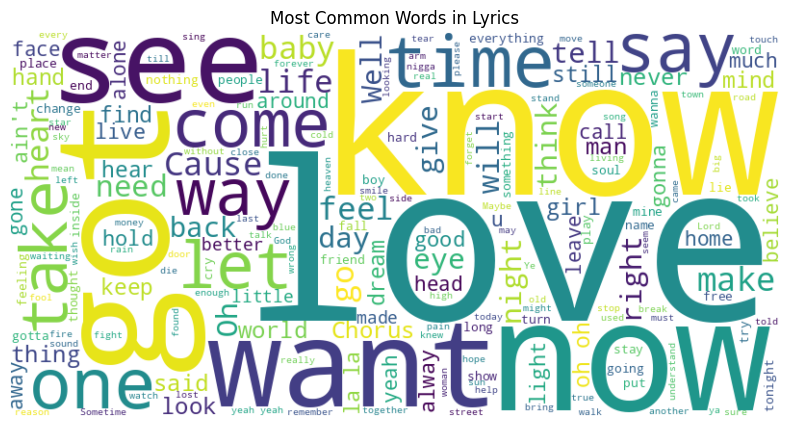

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Lyrics")
plt.show()

data preprocessing

In [ ]:
# download nltk data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
def preprocess_text(text):
    # Remove special characters and numbers
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize and remove stopwords
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [ ]:
df['cleaned_text'] = df['text'].apply(preprocess_text)

In [ ]:
df.head()

,artist,song,text,cleaned_text
0,Poison,Little Willy,"North side, east side \r\nLittle Willy, Willy...",north side east side little willy willy wears ...
1,Starship,Stranger,Raindrops falling \r\nWinter feels so gloomy ...,raindrops falling winter feels gloomy hear kno...
2,Counting Crows,Chelsea,I never go to New York City these days \r\nSo...,never go new york city days something building...
3,David Bowie,Do Anything You Say,"Two by two, they go walking by \r\nHand in ha...",two two go walking hand hand watch cry two two...
4,Helloween,Future World,If you're out there all alone \r\nAnd you don...,youre alone dont know go come take trip future...


In [ ]:
# Vectorization with TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])

In [ ]:
# Compute Cosine Similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [ ]:
# Recommendation Function
def recommend_songs(song_name, cosine_sim=cosine_sim, df=df, top_n=5):
    # Find the index of the song
    idx = df[df['song'].str.lower() == song_name.lower()].index
    if len(idx) == 0:
        return "Song not found in the dataset!"   # can be reworked to compare for songs not present in the dataset
    idx = idx[0]

    # Get similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]

    # Get song indices
    song_indices = [i[0] for i in sim_scores]

    # Return top n similar songs
    return df[['artist', 'song']].iloc[song_indices]

In [ ]:
df["song"][2]

'Chelsea'

In [ ]:
# Example Recommendation
print("\nRecommendations for the song 'Blinded By Rainbows':")
recommendations = recommend_songs("For The First Time") # df["song"][2]
print(recommendations)


Recommendations for the song 'Blinded By Rainbows':
                        artist                song
9743  Electric Light Orchestra   Little Town Flirt
5385           Ella Fitzgerald     Beginner's Luck
400             Britney Spears   Luv The Hurt Away
1591             Conway Twitty  First Things First
6074               Cat Stevens            The Hurt
